## Does Fandango still inflate it's movie ratings?

In October 2015, Walt Hickey from FiveThirtyEight published an article where he presented strong evidence suggesting that Fandango's movie rating system was inflating it's ratings. After investigating he found that Fandango would round up their ratings, making movies appear better than they actually were. This led to many false reviews. Fandango recognized it's mistake and said it was due to a bug in their API and that they would immediately fix it. In this project, we'll analyze more recent movie ratings data - scraped by Dataquest.io -  to determine whether or not Fandango is still inflating their movie ratings.

In this analysis we will work with two samples of movie ratings: the data in one sample was collected prior to Hickey's analysis, while the other sample was collected after. 

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# reading in the datasets
df1 = pd.read_csv("fandango_score_comparison.csv")
df2 = pd.read_csv("movie_ratings_16_17.csv")

In [3]:
# preview
df2.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


In [4]:
df1.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [39]:
# filtering for most relevant columns
old = df1[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']]
old.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [32]:
new = df2[['movie', 'year', 'fandango']]
new.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


## Understanding our data

Since our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis. The population of interest is all of the movie ratings on Fandango's website. Because we want to find out whether the parameters of this population changed after Hickey's analysis, we're interested in sampling the population at two different periods in time — prior to and after Hickey's analysis — so we can compare the two states.

The data we're working with was sampled at the moments we need: one sample was taken prior to Hickey's analysis, and the other data was sampled after Hickey's analysis. What we want to do is describe the population of interest, so we need to verify that the samples are representative of that populaton. If our samples are non-representative, our conclusions draw from those samples will be faulty.

I referenced Hickey's article (https://fivethirtyeight.com/features/fandango-movies-ratings/) and the README.md of the dataset's repository to better understand the data. From them we can see that he used the following sampling criteria for the "old" dataset:

- The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
- The movie must have had tickets on sale in 2015.

Because he used that criteria the sampling was not random because he selected only certain movies and excluded others - not giving every movie an equal chance of being picked. This makes the sample non-representative of the target population. Ratings, and opinions, change over time and are known to be subject to temporal trends, so we need to take that into consideration for our analysis.

Using the README.md in the repository for the "new" dataset we find the following criteria:

- The movie must have been released in 2016 or later.
- The movie must have had a considerable number of votes and reviews. Although, there is no clear standard of what a 

The new dataset is also subject to temporal trends making it non-representative.


## Changing the Goal of our Analysis

At this stage in our analysis we can either collect new data or change the goal of our analysis. For the sake of this project we will change the goal of analysis, placing new limitations. Instead of trying to determine whether or not there has been a change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal since it focuses on the ratings over time. 

## Filtering for the Samples We Need

With this new goal, we have two populations of interest:

- All of Fandango's ratings for popular movies released in 2015.
- All of Fandango's ratings for popular movies released in 2016.

Hickey's used a benchmark of 30 fan ratings to categorize a movie as popular - well use the same benchmark (>30).


## Note:

In order to check the representativity of this sample, we will randomly sample 10 movies to see if most of the movies have at least 30 fan ratings.

In [8]:
old.sample(10, random_state=1)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
98,Get Hard (2015),4.0,3.9,5933,0.1
66,The Gift (2015),4.0,3.7,2680,0.3
53,Hot Pursuit (2015),4.0,3.7,2618,0.3
75,San Andreas (2015),4.5,4.3,9749,0.2
121,The Stanford Prison Experiment (2015),4.0,3.9,51,0.1
74,The Hobbit: The Battle of the Five Armies (2014),4.5,4.3,15337,0.2
119,Phoenix (2015),3.5,3.4,70,0.1
128,Mission: Impossible â€“ Rogue Nation (2015),4.5,4.4,8357,0.1
44,Kingsman: The Secret Service (2015),4.5,4.2,15205,0.3
58,Seventh Son (2015),3.5,3.2,1213,0.3


In [10]:
# seeing if any are under 30
sum(old.iloc[:, 3] < 30)

0

In [9]:
new.sample(10, random_state=1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


Since the new dataset didn't come with a rating's column, I had to verify them on Fandango's website. To save time, I only checked the current ratings for "The Stanford Prison Experiment" and "Phoenix" - since they were the lowest number of fan ratings. I found:

- As of right now (October 2018)"The Stanford Prison Experiment" has 68 fan ratings.
- "Phoenix" has 220 fan ratings.

Since both of those movies had over 30 fan ratings in the old dataset, and upon verification, over 30 ratings in the new dataset, we can assume representativity. 

Now, we need to isolate the years 2015 and 2016. In order to this, I'll extract the year from the FILM column in the old dataset.

In [40]:
# extracting only the years
old["year"] = old["FILM"].str[-5:-1]
old.year.head()

/Users/davidaponte/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    2015
1    2015
2    2015
3    2015
4    2015
Name: year, dtype: object

In [43]:
old['year'].value_counts()

2015    129
2014     17
Name: year, dtype: int64

In [45]:
# only 2015
old = old[old['year'] == '2015']
old.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


In [47]:
# filtering for 2016 in the new dataset
new = new[new['year'] == 2016]
new.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
4,A Hologram for the King,2016,3.0
5,A Monster Calls,2016,4.0


In [48]:
old.shape, new.shape

((129, 6), (191, 3))

## Viewing the distribution of ratings

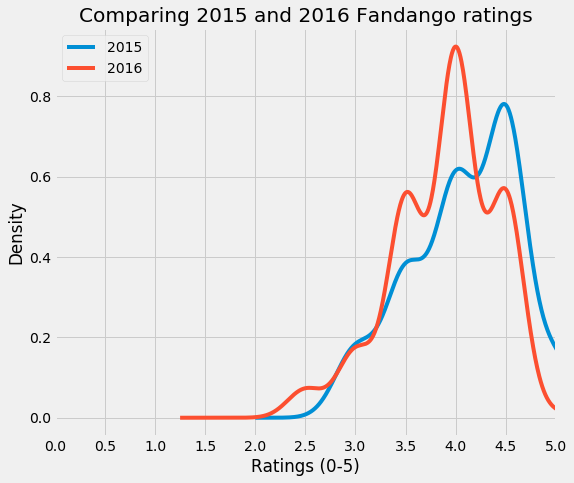

In [68]:
plt.style.use('fivethirtyeight')
x = np.arange(0,5.1,0.5)
old["Fandango_Stars"].plot.kde(label=2015, legend=True, figsize=(8,7))
new['fandango'].plot.kde(label=2016, legend=True)
plt.xticks(x)
plt.xlim(0,5)
plt.xlabel("Ratings (0-5)")
plt.title("Comparing 2015 and 2016 Fandango ratings")
plt.show()


## Findings:

- Both of the distributions have a left skew. I
- The 2015 (old) distribution is more to the right - higher ratings.
- The 2016 (new) distribution is more to the left - lower ratings.
- The difference between the two distributions shows that Fandango had lower ratings in 2016 than it did in 2015. This may be due to Fandango fixing the bug in their API, but we will investigate this further to verify our findings. 
- Fandango, both in 2015 and 2016, tends to give high ratings.



In [74]:
# comparing relative frequencies
old["Fandango_Stars"].value_counts(normalize=True).sort_index(ascending=False)*100

5.0     6.976744
4.5    37.984496
4.0    28.682171
3.5    17.829457
3.0     8.527132
Name: Fandango_Stars, dtype: float64

In [75]:
new["fandango"].value_counts(normalize=True).sort_index(ascending=False)*100

5.0     0.523560
4.5    24.607330
4.0    40.314136
3.5    24.083770
3.0     7.329843
2.5     3.141361
Name: fandango, dtype: float64

## Findings:

- The 2015 ratings are higher than the 2016 ratings. For example, the 5 star ratings decreased by 92.5%.
- The 2016 ratings increased in 4 star ratings by 40.6%. Also, the amount of 3.5 star ratings increased by 35.1%.

To better understand the clear difference between the two distributions we'll visualize their summary statistics.

In [81]:
# summary stats
old["Fandango_Stars"].describe()

count    129.000000
mean       4.085271
std        0.538096
min        3.000000
25%        3.500000
50%        4.000000
75%        4.500000
max        5.000000
Name: Fandango_Stars, dtype: float64

In [79]:
new["fandango"].describe()

count    191.000000
mean       3.887435
std        0.509540
min        2.500000
25%        3.500000
50%        4.000000
75%        4.250000
max        5.000000
Name: fandango, dtype: float64

In [82]:
old["Fandango_Stars"].mode()

0    4.5
dtype: float64

In [83]:
new["fandango"].mode()

0    4.0
dtype: float64

In order to visualize this I'll store the summary stats in variables, then combine them into a dataframe.

In [100]:
old_mean, old_median, old_mode, new_mean, new_median, new_mode = 4.085271, 4.000000, 4.5, 3.887435, 4.000000, 4.0

df = pd.DataFrame()
df['2015'] = [old_mean, old_median, old_mode]
df['2016'] = [new_mean, new_median, new_mode]

df.index = ['Mean', 'Median', 'Mode']
df

,2015,2016
Mean,4.085271,3.887435
Median,4.000000,4.000000
Mode,4.500000,4.000000


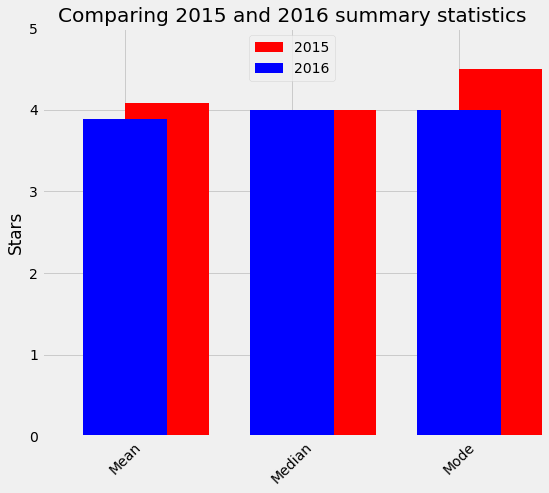

In [124]:
df['2015'].plot.bar(align='edge', color = 'r',label='2015', legend=True, figsize=(8,7))
df['2016'].plot.bar(align='center',color='b',label='2016', legend=True)
plt.ylim(0,5)
plt.legend(loc='upper center')
plt.xticks(rotation=45)
plt.ylabel("Stars")
plt.title("Comparing 2015 and 2016 summary statistics")
plt.show()

## Findings:

- The popular movies on Fandango had lower ratings in 2016 than it did in 2015. This verifies our previous findings.


## Conclusion:

We started this analysis asking whether or not Fandango still inflated their movie ratings. After comparing both distributions we find evidence that the ratings have decreased since 2015, but their ratings, on average, are still fairly high. We cannot be certain whether or not this decrease is due to Fandango fixing the bug, but given their statements on the matter and the on average decrease in ratings, it seems likely.